# V1_SeqGAT_5f_ST — Integrated (temconfigure + temporal_conf + time embedding)

This notebook integrates your dataset & model code with the temporal pipeline:
- `temconfigure` to control if/how `temporal_conf` is used as temporal edge features;
- automatic creation/calibration of `edge_attr_t`;
- optional node time embedding (`time_emb_dim`);
- safe attachment before splitting, with `edge_dim_t` inferred from `temconfigure`.


In [1]:
# %% Imports & helpers
import os, json, math, random
from typing import Optional

import torch
from torch import nn, Tensor
from torch.utils.data import random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv

import matplotlib.pyplot as plt
from data.pt_dataset import load_dataset
from models.seqgat import SeqGAT

try:
    from omegaconf import OmegaConf
except Exception:
    OmegaConf = None

def set_seed(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("torch:", torch.__version__)


/Users/xiemengtong/anaconda3/envs/Tac-VGNN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cpu
torch: 1.12.0


In [2]:
import yaml
cfg = yaml.safe_load(open('configs/seqgat_k5_st.yaml','r'))
cfg

{'seed': 0,
 'data_root': 'data',
 'glob': 'Train_data_list*.pt',
 'field_map': {},
 'tip_num': 331,
 'k_last_frames': 5,
 'val_ratio': 0.2,
 'batch_size': 8,
 'num_workers': 0,
 'in_dim': 3,
 'hidden_dim': 128,
 'num_layers': 4,
 'heads': 4,
 'edge_dim_s': 0,
 'edge_dim_t': 1,
 'time_emb_dim': 16,
 'dropout': 0.1,
 'readout': 'meanmax',
 'lr': 0.0003,
 'weight_decay': 0.0001,
 'optim': 'adam',
 'epochs': 200,
 'patience': 30,
 'label_indices': [0, 1],
 'loss_weights': [1.0, 1.0],
 'save_ckpt': True,
 'out_dir': './outputs/seqgat_st_cal_t16',
 'temconfigure': {'mode': 'raw',
  'lo_q': 0.05,
  'hi_q': 0.995,
  'gamma': 0.6,
  'floor': 0.1}}

In [3]:
# Normalize OmegaConf -> dict
if OmegaConf is not None and not isinstance(cfg, dict):
    cfg = OmegaConf.to_container(cfg, resolve=True)

# temconfigure defaults
cfg.setdefault('temconfigure', {})
tc = cfg['temconfigure']
tc.setdefault('mode', 'calibrated')   # off | raw | calibrated | binary@0.7
tc.setdefault('lo_q', 0.05)
tc.setdefault('hi_q', 0.995)
tc.setdefault('gamma', 0.6)
tc.setdefault('floor', 0.1)

# model defaults (time emb)
cfg.setdefault('model', {})
cfg['model'].setdefault('time_emb_dim', cfg.get('time_emb_dim', 0))
cfg['model'].setdefault('max_frames', 64)

# expose top-level alias for compatibility with your existing code
cfg.setdefault('time_emb_dim', cfg['model']['time_emb_dim'])

# training defaults
cfg.setdefault('batch_size', 8)
cfg.setdefault('val_ratio', 0.2)
cfg.setdefault('num_workers', 0)
cfg.setdefault('seed', 0)

print("[temconfigure] ->", cfg['temconfigure'])
print("[time_emb_dim] ->", cfg['time_emb_dim'])


[temconfigure] -> {'mode': 'raw', 'lo_q': 0.05, 'hi_q': 0.995, 'gamma': 0.6, 'floor': 0.1}
[time_emb_dim] -> 16


In [4]:
# %% Patch: temporal_conf calibration + transforms + attach
from torch_geometric.transforms import Compose

# @torch.no_grad()
# def calibrate_conf_global(c: Tensor, lo_q=0.05, hi_q=0.995, gamma=0.6, floor: Optional[float]=None) -> Tensor:
#     c_ = c.float().view(-1)
#     lo = torch.quantile(c_, torch.tensor(lo_q, device=c_.device))
#     hi = torch.quantile(c_, torch.tensor(hi_q, device=c_.device))
#     cc = (c_.clamp(lo, hi) - lo) / (hi - lo + 1e-8)
#     if floor is not None:
#         cc = torch.clamp(cc, min=float(floor))
#     cc = cc.clamp(0, 1).pow(gamma)
#     return cc.view_as(c)

@torch.no_grad()
def calibrate_conf_global(c: Tensor, lo_q=0.05, hi_q=0.995, gamma=0.6, floor: Optional[float]=None) -> Tensor:
    c_ = c.float().view(-1)
    lo = torch.quantile(c_, torch.tensor(lo_q, device=c_.device))
    hi = torch.quantile(c_, torch.tensor(hi_q, device=c_.device))
    z  = ((c_.clamp(lo, hi) - lo) / (hi - lo + 1e-8)).clamp(0, 1)
    z  = z.pow(gamma)                 # 先幂变换
    if floor is not None:
        z = torch.clamp(z, min=float(floor))  # 再做下限截断，避免 0.1 -> 0.25 的“针”
    return z.view_as(c)

class AddTemporalEdgeAttr(object):
    """Build/calibrate temporal edge features.
    Accepts: data.temporal_conf  OR  (edge_attr, edge_type==1)  OR existing edge_attr_t.
    Produces: data.edge_attr_t: [E_t,1] (float32)
    """
    def __init__(self, cfg: dict, conf_col: int = 0, temporal_type: int = 1):
        self.cfg = cfg
        self.conf_col = conf_col
        self.temporal_type = temporal_type
    def __call__(self, data: Data) -> Data:
        mode = self.cfg['temconfigure']['mode']
        if mode == 'off':
            data.edge_attr_t = None
            return data
        # fetch conf
        if hasattr(data, 'temporal_conf'):
            conf = data.temporal_conf.float()
        elif hasattr(data, 'edge_attr_t') and data.edge_attr_t is not None:
            conf = data.edge_attr_t.float()[:,0]
        elif hasattr(data, 'edge_attr') and hasattr(data, 'edge_type'):
            mask_t = (data.edge_type == self.temporal_type)
            data.edge_index_t = data.edge_index[:, mask_t]
            conf = data.edge_attr[mask_t, self.conf_col].float()
        else:
            return data
        
        # # 2) 取到 conf 之后，立刻备份为 raw
        # data.temporal_conf_raw = conf.detach().clone()

        # strategy
        if mode == 'raw':
            conf_use = conf
        elif mode.startswith('binary'):
            tau = float(mode.split('@')[1]) if '@' in mode else 0.7
            conf_use = (conf >= tau).float()
        elif mode == 'calibrated':
            tcfg = self.cfg['temconfigure']
            conf_use = calibrate_conf_global(conf, tcfg['lo_q'], tcfg['hi_q'], tcfg['gamma'], tcfg.get('floor'))
        else:
            raise ValueError(f"Unknown temconfigure.mode={mode}")
        data.edge_attr_t = conf_use.view(-1,1).contiguous()
        return data

class AddTimeEncoding(object):
    """Ensure data.node_t exists; if only `t` exists, copy to node_t."""
    def __init__(self, markers_per_frame: Optional[int] = 331):
        self.M = markers_per_frame
    def __call__(self, data: Data) -> Data:
        if hasattr(data, 'node_t') and data.node_t is not None:
            return data
        if hasattr(data, 't') and data.t is not None:
            data.node_t = data.t.long()
            return data
        N = data.num_nodes
        if self.M and N % self.M == 0:
            frames = N // self.M
            t = torch.arange(frames, dtype=torch.long)
            data.node_t = t.repeat_interleave(self.M)
        else:
            data.node_t = torch.zeros(N, dtype=torch.long)
        return data

class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, base, transform=None):
        self.base = base
        self.transform = transform
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        data = self.base[idx]
        return self.transform(data) if self.transform else data

@torch.no_grad()
def attach_temporal_pipeline(ds, cfg: dict, markers_per_frame: int = 331):
    mode = cfg['temconfigure']['mode']
    edge_dim_t_effective = 0 if mode == 'off' else 1
    tfm = Compose([AddTemporalEdgeAttr(cfg), AddTimeEncoding(markers_per_frame)])
    if hasattr(ds, 'transform'):
        if ds.transform is None:
            ds.transform = tfm
        else:
            old = ds.transform
            ds.transform = lambda d: tfm(old(d))
        ds_wrapped = ds
    else:
        ds_wrapped = TransformDataset(ds, transform=tfm)
    return ds_wrapped, edge_dim_t_effective

@torch.no_grad()
def sanity_check_one_batch(loader, use_temporal=True):
    for data in loader:
        Es = getattr(data,'edge_index_s', None)
        Et = getattr(data,'edge_index_t', None)
        print("N=", data.num_nodes,
              "Es=", None if Es is None else Es.shape[1],
              "Et=", None if Et is None else Et.shape[1])
        if use_temporal:
            ea = getattr(data, 'edge_attr_t', None)
            print("edge_attr_t:", None if ea is None else tuple(ea.shape))
        t = getattr(data,'node_t', None)
        if t is not None:
            print("node_t: min/max", int(t.min()), int(t.max()))
        break


In [5]:
ds = load_dataset(
    cfg['data_root'],
    glob_pattern=cfg.get('glob','Train_*.pt'),
    field_map=cfg.get('field_map',{}),
    tip_num=cfg.get('tip_num'),
    k_last_frames=cfg.get('k_last_frames'),
)

# if cfg['data_root'].endswith(".pt") and os.path.isfile(cfg['data_root']):
#     ds = torch.load(cfg['data_root'])  # 如果是保存的图列表 .pt 文件
# else:
#     ds = load_dataset(
#         cfg['data_root'],
#         glob_pattern=cfg.get('glob', 'Train_*.pt'),
#         field_map=cfg.get('field_map', {}),
#         tip_num=cfg.get('tip_num'),
#         k_last_frames=cfg.get('k_last_frames'),
#     )

print('Total samples:', len(ds))

# Attach temporal pipeline BEFORE splitting
ds, edge_dim_t_eff = attach_temporal_pipeline(ds, cfg)

if len(ds) > 0:
    d0 = ds[0]
    print('x:', tuple(d0.x.shape))
    print('y:', tuple(d0.y.shape))
    print('t: min/max', int(d0.t.min()), int(d0.t.max()) if hasattr(d0,'t') else 'NA')
    print('Es:', getattr(d0,'edge_index_s', None).shape if hasattr(d0,'edge_index_s') else None)
    print('Et:', getattr(d0,'edge_index_t', None).shape if hasattr(d0,'edge_index_t') else None)
    print('Et_attr:', getattr(d0,'edge_attr_t', None).shape if hasattr(d0,'edge_attr_t') else None)

set_seed(cfg.get('seed',0))


n_total = len(ds)
n_val = int(n_total * cfg.get('val_ratio', 0.2))
n_train = n_total - n_val
print('Split -> train:', n_train, 'val:', n_val)

train_set, val_set = random_split(
    ds, [n_train, n_val],
    generator=torch.Generator().manual_seed(cfg.get('seed',0))
)

train_loader = DataLoader(train_set, batch_size=cfg.get('batch_size',8), shuffle=True,  num_workers=cfg.get('num_workers',0))
val_loader   = DataLoader(val_set,   batch_size=cfg.get('batch_size',8), shuffle=False, num_workers=cfg.get('num_workers',0))

cfg['edge_dim_t'] = int(edge_dim_t_eff)  # 0 or 1
print('[edge_dim_t] ->', cfg['edge_dim_t'])
sanity_check_one_batch(train_loader, use_temporal=(cfg['edge_dim_t']==1))


Total samples: 144
x: (1655, 3)
y: (2,)
t: min/max 15 19
Es: torch.Size([2, 9300])
Et: torch.Size([2, 1192])
Et_attr: torch.Size([1192, 1])
Split -> train: 116 val: 28
[edge_dim_t] -> 1
N= 13240 Es= 74402 Et= 8937
edge_attr_t: (8937, 1)
node_t: min/max 15 19


In [6]:
# %% [code] -- one-click temporal_conf histogram by mode
import copy, torch
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

def _desc(v: torch.Tensor, tag=""):
    v = v.float()
    if v.numel() == 0:
        print(f"[{tag}] empty")
        return
    qs = torch.tensor([0.01,0.05,0.1,0.5,0.9,0.95,0.99])
    qv = torch.quantile(v, qs).cpu().numpy().tolist()
    print(f"[{tag}] n={v.numel():,} min={v.min().item():.4f} max={v.max().item():.4f} mean={v.mean().item():.4f} std={v.std().item():.4f}")
    print(" quantiles:", {int(q*100): round(x,4) for q,x in zip(qs, qv)})

@torch.no_grad()
def _collect_edge_attr_t(loader):
    vals = []
    for data in loader:
        ea = getattr(data, "edge_attr_t", None)
        if ea is None: continue
        vals.append(ea[:,0].float().cpu())
    return torch.cat(vals) if vals else torch.tensor([])

def make_loader_for_mode(base_cfg: dict, mode: str):
    cfg_local = copy.deepcopy(base_cfg)
    cfg_local.setdefault("temconfigure", {})
    cfg_local["temconfigure"]["mode"] = mode
    # Rebuild split
    base = load_dataset(cfg_local['data_root'],
                        glob_pattern=cfg_local.get('glob','*.pt'),
                        field_map=cfg_local.get('field_map',{}),
                        tip_num=cfg_local.get('tip_num'),
                        k_last_frames=cfg_local.get('k_last_frames'))
    set_seed(cfg_local.get('seed',0))
    from torch.utils.data import random_split
    n_total = len(base); n_val = int(n_total*cfg_local.get('val_ratio',0.2)); n_train = n_total - n_val
    tr, va = random_split(base, [n_train, n_val],
                          generator=torch.Generator().manual_seed(cfg_local.get('seed',0)))
    tr, _ = attach_temporal_pipeline(tr, cfg_local)
    tl = DataLoader(tr, batch_size=cfg_local.get('batch_size',8), shuffle=False,
                    num_workers=cfg_local.get('num_workers',0))
    return tl, cfg_local

def plot_temporal_by_mode(base_cfg, mode, title=None, bins=60):
    tl, cfg_eff = make_loader_for_mode(base_cfg, mode)
    v = _collect_edge_attr_t(tl)
    if title is None: title = f"temporal_conf(train, mode={mode})"
    plt.figure(figsize=(5,3.2)); plt.hist(v.numpy(), bins=bins)
    plt.title(title); plt.xlabel("temporal_conf"); plt.ylabel("count"); plt.tight_layout(); plt.show()
    _desc(v, tag=title)
    return v

# Example:
# v_raw = plot_temporal_by_mode(cfg, "raw", title="temporal_conf(train, RAW)")
# # cfg['temconfigure'].update({'lo_q':0.05,'hi_q':0.995,'gamma':1.2,'floor':0.0})
# # v_cal = plot_temporal_by_mode(cfg, "calibrated", title="temporal_conf(train, CAL, γ=1.2, floor=0)")
# print("[ready] Use plot_temporal_by_mode(cfg, 'raw'/'calibrated'/'binary@0.75')")

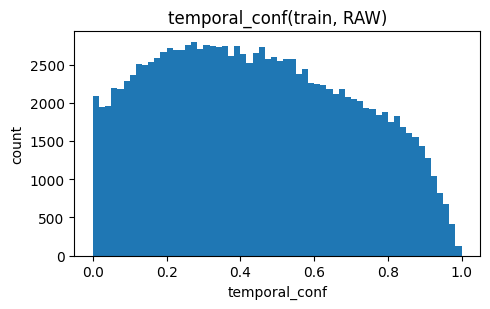

[temporal_conf(train, RAW)] n=129,861 min=0.0000 max=0.9996 mean=0.4427 std=0.2568
 quantiles: {1: 0.0093, 5: 0.0537, 10: 0.1025, 50: 0.4282, 90: 0.8111, 95: 0.8754, 99: 0.9477}


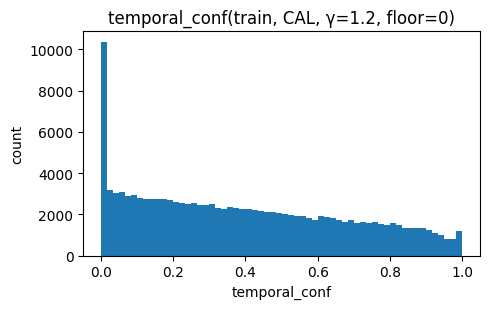

[temporal_conf(train, CAL, γ=1.2, floor=0)] n=129,861 min=0.0000 max=1.0000 mean=0.3922 std=0.2844
 quantiles: {1: 0.0, 5: 0.0, 10: 0.0304, 50: 0.3562, 90: 0.8156, 95: 0.8945, 99: 0.9821}


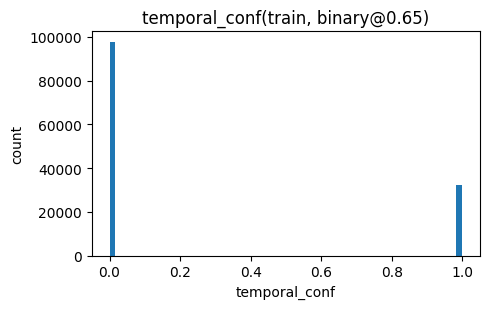

[temporal_conf(train, binary@0.65)] n=129,861 min=0.0000 max=1.0000 mean=0.2478 std=0.4317
 quantiles: {1: 0.0, 5: 0.0, 10: 0.0, 50: 0.0, 90: 1.0, 95: 1.0, 99: 1.0}


In [7]:
# 1) 看 RAW（模型将使用的 edge_attr_t == RAW）
v_raw = plot_temporal_by_mode(cfg, "raw", title="temporal_conf(train, RAW)")

# 2) 推荐的校准参数（避免“0.25 大针”）
# cfg_tmp = copy.deepcopy(cfg)
cfg['temconfigure'].update({'lo_q':0.05, 'hi_q':0.995, 'gamma':1.2, 'floor':0.0})
v_cal = plot_temporal_by_mode(cfg, "calibrated", title="temporal_conf(train, CAL, γ=1.2, floor=0)")

# 3) 二值化（可选）：阈值取 RAW 的 P75
import torch
tau = torch.quantile(v_raw, torch.tensor(0.75)).item()
v_bin = plot_temporal_by_mode(cfg, f"binary@{tau:.2f}", title=f"temporal_conf(train, binary@{tau:.2f})")


In [8]:
# %% Temporal stats (train/val × modes) using attach-then-split approach
import copy, torch
import pandas as pd
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

@torch.no_grad()
def _collect_edge_attr_t(loader):
    vals = []
    for data in loader:
        ea = getattr(data, "edge_attr_t", None)
        if ea is not None:
            vals.append(ea[:,0].float().cpu())
    return torch.cat(vals) if vals else torch.tensor([])

def stats_vec(x: torch.Tensor):
    x = x.float()
    q = torch.tensor([0.01,0.05,0.50,0.95,0.99])
    return {
        "n": int(x.numel()),
        "min": float(x.min()), "max": float(x.max()),
        "p01": float(torch.quantile(x, q[0])), "p05": float(torch.quantile(x, q[1])),
        "p50": float(torch.quantile(x, q[2])), "p95": float(torch.quantile(x, q[3])),
        "p99": float(torch.quantile(x, q[4])),
        "frac<=0.01": float((x <= 0.01).float().mean()),
        "frac>=0.95": float((x >= 0.95).float().mean()),
        "mean": float(x.mean()), "std": float(x.std()),
    }

def loaders_attach_then_split(base_cfg: dict, tem_mode: str):
    cfg_local = copy.deepcopy(base_cfg)
    cfg_local.setdefault("temconfigure", {})
    cfg_local["temconfigure"]["mode"] = tem_mode
    ds = load_dataset(cfg_local['data_root'],
                      glob_pattern=cfg_local.get('glob','*.pt'),
                      field_map=cfg_local.get('field_map',{}),
                      tip_num=cfg_local.get('tip_num'),
                      k_last_frames=cfg_local.get('k_last_frames'))
    ds, _ = attach_temporal_pipeline(ds, cfg_local)
    set_seed(cfg_local.get('seed', 0))
    n_total = len(ds)
    n_val = int(n_total * cfg_local.get('val_ratio', 0.2))
    n_train = n_total - n_val
    train_set, val_set = random_split(ds, [n_train, n_val],
                                      generator=torch.Generator().manual_seed(cfg_local.get('seed', 0)))
    train_loader = DataLoader(train_set, batch_size=cfg_local.get('batch_size', 8), shuffle=False)
    val_loader   = DataLoader(val_set,   batch_size=cfg_local.get('batch_size', 8), shuffle=False)
    return train_loader, val_loader

def temporal_stats_table_by_modes(base_cfg, mode_list):
    rows = []
    for name, mode_str in mode_list:
        tr_loader, va_loader = loaders_attach_then_split(base_cfg, mode_str)
        vtr = _collect_edge_attr_t(tr_loader)
        vva = _collect_edge_attr_t(va_loader)
        rows.append({"split":"train","mode":name, **stats_vec(vtr)})
        rows.append({"split":"val",  "mode":name, **stats_vec(vva)})
    df = pd.DataFrame(rows)
    df = df[["split","mode","n","min","max","p01","p05","p50","p95","p99","frac<=0.01","frac>=0.95","mean","std"]]
    return df
# --- 准备 modes ---
modes = [
    ("raw", "raw"),
    ("cal12_f0", "calibrated"),
]

# 应用推荐校准参数
cfg['temconfigure'].update({'lo_q': 0.05, 'hi_q': 0.995, 'gamma': 1.2, 'floor': 0.0})

# --- 计算 RAW 模式下的 P75 作为 binary 阈值 ---
v_raw_loader, _ = loaders_attach_then_split(cfg, "raw")
v_raw_train = _collect_edge_attr_t(v_raw_loader)
tau = float(torch.quantile(v_raw_train, torch.tensor(0.75)))
modes.append((f"binary@{tau:.2f}", f"binary@{tau:.2f}"))

# --- 生成表格并导出 ---
df = temporal_stats_table_by_modes(cfg, modes)
print(df)

csv_path = "data/temporal_stats.csv"
df.to_csv(csv_path, index=False)
print("Saved ->", csv_path)


   split         mode       n  min       max       p01       p05       p50  \
0  train          raw  129861  0.0  0.999572  0.009255  0.053720  0.428160   
1    val          raw   31657  0.0  0.998431  0.011364  0.065683  0.471743   
2  train     cal12_f0  129861  0.0  1.000000  0.000000  0.000000  0.356228   
3    val     cal12_f0   31657  0.0  1.000000  0.000000  0.000000  0.398915   
4  train  binary@0.65  129861  0.0  1.000000  0.000000  0.000000  0.000000   
5    val  binary@0.65   31657  0.0  1.000000  0.000000  0.000000  0.000000   

        p95       p99  frac<=0.01  frac>=0.95      mean       std  
0  0.875418  0.947718    0.010619    0.009256  0.442724  0.256776  
1  0.851465  0.934328    0.009129    0.005718  0.465237  0.243367  
2  0.894474  0.982135    0.069528    0.021600  0.392183  0.284428  
3  0.861428  0.977241    0.066273    0.016963  0.407513  0.270680  
4  1.000000  1.000000    0.752235    0.247765  0.247765  0.431716  
5  1.000000  1.000000    0.735098    0.264902

## Seqgat Model Loading

In [9]:
# %% Model — SeqGAT init integrated

try:
    SeqGAT  # noqa
except NameError:
    # e.g., from models.seqgat import SeqGAT
    print("⚠️ Please import your SeqGAT class before running this cell.")
    # from models.seqgat import SeqGAT  # <- uncomment & edit

model = SeqGAT(
    in_dim=cfg['in_dim'],
    hidden_dim=cfg.get('hidden_dim',128),
    num_layers=cfg.get('num_layers',4),
    heads=cfg.get('heads',4),
    edge_dim_s=cfg.get('edge_dim_s',0),
    edge_dim_t=cfg.get('edge_dim_t',0),         # 
    time_emb_dim=cfg.get('time_emb_dim',16),    #
    dropout=cfg.get('dropout',0.1),
    readout=cfg.get('readout','meanmax'),
).to(device)

param_count = sum(p.numel() for p in model.parameters())
print("Model params:", param_count)


Model params: 1097602


In [10]:
# %% (Optional) quick training skeleton
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.get('lr', 3e-4))
criterion = nn.MSELoss()

def run_epoch(loader, train=True):
    model.train(train)
    total, count = 0.0, 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        if not hasattr(data, 'y') or data.y is None:
            raise RuntimeError("Dataset must have 'y' targets.")
        loss = criterion(out, data.y)
        if train:
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        total += float(loss.item())
        count += 1
    return total / max(count,1)

# E = 1  # uncomment to do a smoke test
# for ep in range(1, E+1):
#     tr = run_epoch(train_loader, True)
#     va = run_epoch(val_loader, False)
#     print(f"Ep{ep:03d} | train={tr:.4f} | val={va:.4f}")


## Selcet the best configuration - Run before the main training

## 🔬 Experiment Grid Runner

This section runs the **A/B/C baselines** with multiple seeds and logs results to a CSV.

**Configs**:
- A: `mode=off`, `time_emb_dim=0`
- B: `mode=off`, `time_emb_dim=16`
- C: `mode=calibrated`, `time_emb_dim=16` (gamma=0.6, floor=0.1)

Outputs:
- CSV at `/data/seqgat_runs.csv`
- A quick bar chart of best validation MAE per run



==== RUN: B_off_t16 | seed=0 | mode=raw | t_emb=16
Ep001 | train_MAE=4.4950(Y=1.044, θ=7.945) | val_MAE=3.7934(Y=0.882, θ=6.705)
Ep002 | train_MAE=4.4362(Y=1.002, θ=7.871) | val_MAE=3.7601(Y=0.928, θ=6.592)
Ep004 | train_MAE=4.0134(Y=1.045, θ=6.982) | val_MAE=3.5080(Y=0.894, θ=6.122)
Ep006 | train_MAE=3.4057(Y=1.022, θ=5.790) | val_MAE=3.2187(Y=0.897, θ=5.540)
Ep008 | train_MAE=2.8999(Y=0.988, θ=4.811) | val_MAE=3.1199(Y=0.895, θ=5.345)
Ep010 | train_MAE=2.5653(Y=0.961, θ=4.170) | val_MAE=3.0775(Y=0.915, θ=5.240)

==== RUN: B_off_t16 | seed=1 | mode=raw | t_emb=16
Ep001 | train_MAE=4.3391(Y=0.993, θ=7.686) | val_MAE=4.5595(Y=1.087, θ=8.032)
Ep002 | train_MAE=4.2391(Y=0.976, θ=7.503) | val_MAE=4.4651(Y=1.080, θ=7.851)
Ep004 | train_MAE=4.0016(Y=1.061, θ=6.942) | val_MAE=4.3996(Y=1.101, θ=7.698)
Ep006 | train_MAE=3.2454(Y=0.958, θ=5.533) | val_MAE=3.5482(Y=1.079, θ=6.017)
Ep008 | train_MAE=2.9195(Y=0.945, θ=4.894) | val_MAE=3.0844(Y=1.079, θ=5.090)
Ep010 | train_MAE=2.7268(Y=0.927, θ=4.

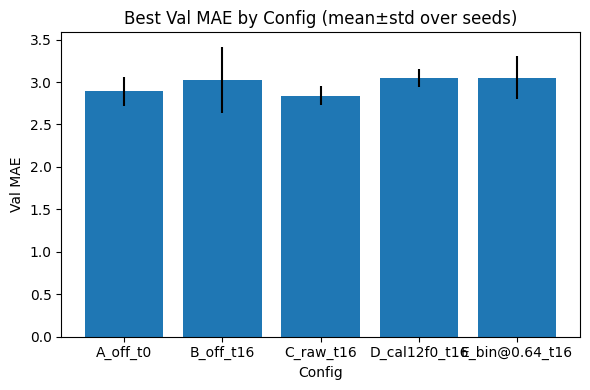

In [18]:
##  this one correct
# %% [code] -- Experiment grid (A/B/C) with multi-seed logging
import os, copy, csv, time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Helpers to deep-set nested dict keys like "temconfigure.mode" ---
def cfg_set(cfg: dict, dotted_key: str, value):
    keys = dotted_key.split(".")
    d = cfg
    for k in keys[:-1]:
        if k not in d or not isinstance(d[k], dict):
            d[k] = {}
        d = d[k]
    d[keys[-1]] = value

def make_cfg(base: dict, overrides: dict):
    cfg_local = copy.deepcopy(base)
    for k, v in overrides.items():
        if "." in k:
            cfg_set(cfg_local, k, v)
        else:
            cfg_local[k] = v
    return cfg_local



def build_loaders_with_pipeline(cfg_local: dict):
    global load_dataset  # expect already imported
    root = cfg_local['data_root']

    # === 支持文件列表或目录+glob ===
    if root.endswith('.pt') and os.path.isfile(root):
        # 单文件：内部是 list[Data]
        ds = torch.load(root)
    else:
        # 目录：需要 glob 规则来读取多个 .pt 文件
        ds = load_dataset(
            root,
            glob_pattern=cfg_local.get('glob','*.pt'),
            field_map=cfg_local.get('field_map',{}),
            tip_num=cfg_local.get('tip_num'),
            k_last_frames=cfg_local.get('k_last_frames'),
        )

    # === 加入 temporal pipeline ===
    ds, edge_dim_t_eff = attach_temporal_pipeline(ds, cfg_local)
    cfg_local['edge_dim_t'] = int(edge_dim_t_eff)

    # === 训练/验证划分 ===
    n_total = len(ds)
    n_val = int(n_total * cfg_local.get('val_ratio', 0.2))
    n_train = n_total - n_val

    set_seed(cfg_local.get('seed', 0))
    train_set, val_set = random_split(
        ds, [n_train, n_val],
        generator=torch.Generator().manual_seed(cfg_local.get('seed', 0))
    )

    train_loader = DataLoader(train_set, batch_size=cfg_local.get('batch_size', 8),
                              shuffle=True,  num_workers=cfg_local.get('num_workers', 0))
    val_loader   = DataLoader(val_set,   batch_size=cfg_local.get('batch_size', 8),
                              shuffle=False, num_workers=cfg_local.get('num_workers', 0))

    return train_loader, val_loader, cfg_local

# --- Metrics (MAE overall + per-dim if 2-D) ---
@torch.no_grad()
def eval_mae(loader, model, device):
    model.eval()
    abs_list = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        y = data.y
        if y.shape != out.shape and y.numel() == out.numel():
            y = y.view_as(out)
        abs_list.append((out - y).abs().detach().cpu())
    if not abs_list:
        return float("nan"), None
    abs_all = torch.cat(abs_list, dim=0)
    mae = float(abs_all.mean().item())
    mae_perdim = abs_all.mean(dim=0).cpu().tolist() if (abs_all.ndim==2 and abs_all.size(1)<=8) else None
    return mae, mae_perdim

def train_one(cfg_local: dict, epochs=30, lr=None):
    # loaders
    train_loader, val_loader, cfg_eff = build_loaders_with_pipeline(cfg_local)
    # model (expects SeqGAT imported)
    global SeqGAT  # expect user import done earlier
    model = SeqGAT(
        in_dim=cfg_eff['in_dim'],
        hidden_dim=cfg_eff.get('hidden_dim',128),
        num_layers=cfg_eff.get('num_layers',4),
        heads=cfg_eff.get('heads',4),
        edge_dim_s=cfg_eff.get('edge_dim_s',0),
        edge_dim_t=cfg_eff.get('edge_dim_t',0),
        time_emb_dim=cfg_eff.get('time_emb_dim',16),
        dropout=cfg_eff.get('dropout',0.1),
        readout=cfg_eff.get('readout','meanmax'),
    ).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg_eff.get('lr', 3e-4) if lr is None else lr)
    crit = nn.MSELoss()

    best = {"val_mae": float("inf"), "epoch": -1, "train_mae": None,
            "val_mae_perdim": None, "train_mae_perdim": None}

    for ep in range(1, epochs+1):
        model.train()
        for data in train_loader:
            data = data.to(device)
            out = model(data)
            y = data.y
            if y.shape != out.shape and y.numel() == out.numel():
                y = y.view_as(out)
            loss = crit(out, y)
            opt.zero_grad(); loss.backward(); opt.step()

        # eval
        tr_mae, tr_pd = eval_mae(train_loader, model, device)
        va_mae, va_pd = eval_mae(val_loader,   model, device)

        if va_mae < best["val_mae"]:
            best.update(val_mae=va_mae, epoch=ep, train_mae=tr_mae,
                        val_mae_perdim=va_pd, train_mae_perdim=tr_pd)

        def fmt(pd): return f"(Y={pd[0]:.3f}, θ={pd[1]:.3f})" if pd and len(pd)>=2 else ""
        if ep % max(1, epochs//5) == 0 or ep == 1:
            print(f"Ep{ep:03d} | train_MAE={tr_mae:.4f}{fmt(tr_pd)} | val_MAE={va_mae:.4f}{fmt(va_pd)}")

    return best

# --- helper: compute P75 threshold for binary from RAW ---
@torch.no_grad()
def p75_tau_from_raw(cfg_base: dict):
    cfg_tmp = copy.deepcopy(cfg_base)
    cfg_tmp.setdefault('temconfigure', {})['mode'] = 'raw'
    ds = load_dataset(cfg_tmp['data_root'],
                      glob_pattern=cfg_tmp.get('glob','*.pt'),
                      field_map=cfg_tmp.get('field_map',{}),
                      tip_num=cfg_tmp.get('tip_num'),
                      k_last_frames=cfg_tmp.get('k_last_frames'))
    ds, _ = attach_temporal_pipeline(ds, cfg_tmp)
    # take first few batches to estimate
    from torch_geometric.loader import DataLoader
    dl = DataLoader(ds, batch_size=cfg_tmp.get('batch_size',8), shuffle=False)
    vals = []
    for i, d in enumerate(dl):
        if getattr(d, "edge_attr_t", None) is None: continue
        vals.append(d.edge_attr_t[:,0].float().cpu())
        if i >= 10: break
    v = torch.cat(vals) if vals else torch.tensor([0.7])
    return float(torch.quantile(v, torch.tensor(0.75)))

# --- Define experiment grid ---
tau = p75_tau_from_raw(cfg)  # robust取 RAW 的 P75
grid = [
 

    {"name": "B_off_t16",  "temconfigure.mode": "raw",  "time_emb_dim": 16},
     {"name": "A_off_t0",   "temconfigure.mode": "off",  "time_emb_dim": 0},
    {"name": "C_raw_t16",  "temconfigure.mode": "off",  "time_emb_dim": 16},
    {"name": "D_cal12f0_t16",
     "temconfigure.mode": "calibrated",
     "temconfigure.lo_q": 0.05, "temconfigure.hi_q": 0.995,
     "temconfigure.gamma": 1.2, "temconfigure.floor": 0.0,
     "time_emb_dim": 16},

    {"name": f"E_bin@{tau:.2f}_t16",
     "temconfigure.mode": f"binary@{tau:.2f}",
     "time_emb_dim": 16},
]

seeds  = [0,1,2]   # 快速可用 [0]，正式再跑多seed
EPOCHS = 10        # 快速比较；正式训练再加长
results_csv = "data/seqgat_runs.csv"
os.makedirs(os.path.dirname(results_csv), exist_ok=True)

# --- Run grid ---
rows = []
t0 = time.time()
for g in grid:
    for s in seeds:
        overrides = dict(g)
        name = overrides.pop("name")
        overrides["seed"] = s
        cfg_local = make_cfg(cfg, overrides)
        print(f"\n==== RUN: {name} | seed={s} | mode={cfg_local['temconfigure']['mode']} | t_emb={cfg_local['time_emb_dim']}")
        best = train_one(cfg_local, epochs=EPOCHS)
        row = {
            "name": name, "seed": s,
            "mode": cfg_local['temconfigure']['mode'],
            "time_emb_dim": cfg_local['time_emb_dim'],
            "gamma": cfg_local['temconfigure'].get('gamma', None),
            "floor": cfg_local['temconfigure'].get('floor', None),
            "best_val_mae": best["val_mae"],
            "best_epoch": best["epoch"],
            "best_train_mae": best["train_mae"],
        }
        if best.get("val_mae_perdim"):
            row["best_val_mae_Y"] = best["val_mae_perdim"][0]
            row["best_val_mae_theta"] = best["val_mae_perdim"][1]
        rows.append(row)

# Write CSV
import pandas as pd
df = pd.DataFrame(rows).sort_values(["name","seed"])
df.to_csv(results_csv, index=False)
print("Saved results ->", results_csv)

# Aggregate & print summary
summary = df.groupby("name")["best_val_mae"].agg(["mean","std","count"]).reset_index()
print("\nSummary (val MAE):\n", summary)

# Plot bar chart
plt.figure(figsize=(6,4))
plt.bar(summary["name"], summary["mean"], yerr=summary["std"])
plt.title("Best Val MAE by Config (mean±std over seeds)")
plt.xlabel("Config"); plt.ylabel("Val MAE"); plt.tight_layout(); plt.show()


## 👀 Attention Inspection (GAT α) — Run after the main training below

This section captures **GAT attention weights** (per layer), summarizes whether attention is too sharp or too flat, and optionally plots histograms.

**Usage:**
1. Make sure `model` and `val_loader` are defined (they are, if you executed previous cells).
2. Run the code cell below; it will patch GAT layers to capture `alpha` without changing outputs.


In [12]:
# %% [code] -- Attention capture + summary (safe)
import math
import torch
from torch import nn
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt

try:
    from torch_geometric.nn import TransformerConv, GATConv, GATv2Conv
    GAT_LIKE = (TransformerConv, GATConv, GATv2Conv)
except Exception:
    from torch_geometric.nn import TransformerConv, GATConv
    GAT_LIKE = (TransformerConv, GATConv)

class CaptureAttention(nn.Module):
    """Wrap a GAT-like conv; force return_attention_weights=True; store (edge_index, alpha)."""
    def __init__(self, conv, name: str):
        super().__init__()
        self.conv = conv
        self.name = name
        self.last_edge_index = None
        self.last_alpha = None
    def forward(self, x, edge_index, edge_attr=None, **kwargs):
        # TransformerConv / GATConv 接口略有差别，优先传 edge_attr
        try:
            out, (ei, alpha) = self.conv(x, edge_index, edge_attr=edge_attr, return_attention_weights=True)
        except TypeError:  # 某些实现可能用 edge_weight
            out, (ei, alpha) = self.conv(x, edge_index, edge_weight=edge_attr, return_attention_weights=True)
        self.last_edge_index = ei
        self.last_alpha = alpha
        return out

def patch_gat_for_alpha(model: nn.Module):
    """Patch all TransformerConv/GAT-like layers for attention capture."""
    root = model.module if hasattr(model, "module") else model
    captures = {}
    def _walk(m: nn.Module, prefix=""):
        for name, ch in list(m.named_children()):
            full = f"{prefix}.{name}" if prefix else name
            if isinstance(ch, GAT_LIKE):
                cap = CaptureAttention(ch, full)
                setattr(m, name, cap)
                captures[full] = cap
            else:
                _walk(ch, full)
    _walk(root)
    if captures:
        print("[AttentionProbe] Patched layers:")
        for k in captures: print("  -", k)
    else:
        print("[AttentionProbe] No GAT-like layers found; check model type or call after building model.")
    # 存到最外层 model 上
    (model.module if hasattr(model, "module") else model)._alpha_captures = captures
    return captures


def _concat_list(tensors: List[torch.Tensor]) -> Optional[torch.Tensor]:
    tensors = [t for t in tensors if t is not None]
    if not tensors: return None
    return torch.cat([t.detach().cpu() for t in tensors], dim=0)

def _per_dst_groups(alpha_1d: torch.Tensor, dst: torch.Tensor):
    probs_per_node = []
    degrees = []
    if alpha_1d.numel() == 0: return probs_per_node, degrees
    unique_dst = torch.unique(dst)
    for i in unique_dst.tolist():
        idx = (dst == i).nonzero(as_tuple=False).view(-1)
        if idx.numel() <= 1:  # need >=2 to judge distribution
            continue
        p = alpha_1d[idx].clamp_min(1e-12)
        p = p / p.sum()
        probs_per_node.append(p)
        degrees.append(p.numel())
    return probs_per_node, degrees

def _summarize_node_probs(probs_per_node: List[torch.Tensor]):
    if not probs_per_node: return {}
    top1 = []
    nH = []
    for p in probs_per_node:
        if p.numel() <= 1: continue
        top1.append(float(p.max().item()))
        H = float(-(p * p.log()).sum().item())
        nH.append(H / math.log(p.numel()))
    if not top1: return {}
    t = torch.tensor(top1)
    h = torch.tensor(nH)
    def qstats(x, qs=(0.5, 0.9, 0.95, 0.99)):
        qv = torch.quantile(x, torch.tensor(qs))
        return {f"p{int(q*100)}": float(v) for q, v in zip(qs, qv)}
    return {
        "top1_mean": float(t.mean().item()),
        "top1_frac_ge_0.9": float((t >= 0.9).float().mean().item()),
        "top1_quantiles": qstats(t),
        "nH_mean": float(h.mean().item()),
        "nH_frac_le_0.5": float((h <= 0.5).float().mean().item()),
        "nH_quantiles": qstats(h),
        "top1_vals": t,  # return for plotting
        "nH_vals": h,    # return for plotting
    }

@torch.no_grad()
def inspect_alpha(model: torch.nn.Module, loader, device, max_batches: int = 2, plot: bool = True):
    if not hasattr(model, "_alpha_captures") or not model._alpha_captures:
        print("[AttentionProbe] Model not patched; patching now...")
        patch_gat_for_alpha(model)
        if not model._alpha_captures:
            print("[AttentionProbe] Abort: still no GATConv layers.")
            return

    model.eval()
    layer_alphas = defaultdict(list)
    layer_dsts = defaultdict(list)
    heads_info = {}

    # collect a few batches
    for b, data in enumerate(loader):
        data = data.to(device)
        _ = model(data)  # triggers recording inside captures
        for name, cap in model._alpha_captures.items():
            alpha = cap.last_alpha
            ei = cap.last_edge_index
            if alpha is None or ei is None: 
                continue
            # average heads if 2D [E, H]
            if alpha.dim() == 2:
                heads_info[name] = alpha.size(1)
                alpha_1d = alpha.mean(dim=1)
            else:
                heads_info[name] = 1
                alpha_1d = alpha
            layer_alphas[name].append(alpha_1d.detach().cpu())
            layer_dsts[name].append(ei[1].detach().cpu())
        if (b+1) >= max_batches:
            break

    # summarize
    print("\n===== Attention Summary =====")
    for name in model._alpha_captures.keys():
        a_cat = _concat_list(layer_alphas[name])
        d_cat = _concat_list(layer_dsts[name])
        if a_cat is None or d_cat is None or a_cat.numel() == 0:
            print(f"[{name}] No alpha captured (layer not hit or no edges).")
            continue
        probs_per_node, degrees = _per_dst_groups(a_cat, d_cat)
        if not probs_per_node:
            print(f"[{name}] Not enough dst in-degree (>1) to evaluate attention distribution.")
            continue
        stats = _summarize_node_probs(probs_per_node)
        print(f"Layer: {name}  (heads={heads_info.get(name,1)})")
        print(f"  Top1 mean={stats['top1_mean']:.4f} | frac(top1>=0.9)={stats['top1_frac_ge_0.9']:.3f} | {stats['top1_quantiles']}")
        print(f"  nH mean={stats['nH_mean']:.4f} | frac(nH<=0.5)={stats['nH_frac_le_0.5']:.3f} | {stats['nH_quantiles']}")
        if plot:
            # one figure per metric to comply with plotting rules (no style/colors set)
            plt.figure(figsize=(5,3.2))
            plt.hist(stats['top1_vals'].numpy(), bins=40)
            plt.title(f"Top-1 α per dst node — {name}")
            plt.xlabel("top1(alpha)")
            plt.ylabel("nodes")
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(5,3.2))
            plt.hist(stats['nH_vals'].numpy(), bins=40)
            plt.title(f"Normalized entropy H/log(deg) — {name}")
            plt.xlabel("normalized entropy")
            plt.ylabel("nodes")
            plt.tight_layout()
            plt.show()

    print("\nTips:")
    print(" • If many nodes have top1>=0.9 and nH_mean<0.6 ⇒ attention too sharp. Try lower gamma or higher floor.")
    print(" • If nH_mean≈1.0 and top1≈1/degree ⇒ nearly uniform (too flat). Consider gamma↑ or raw mode.")


[AttentionProbe] Patched layers:
  - blocks.0.s_attn
  - blocks.0.t_attn
  - blocks.1.s_attn
  - blocks.1.t_attn
  - blocks.2.s_attn
  - blocks.2.t_attn
  - blocks.3.s_attn
  - blocks.3.t_attn

===== Attention Summary =====
Layer: blocks.0.s_attn  (heads=4)
  Top1 mean=0.2167 | frac(top1>=0.9)=0.000 | {'p50': 0.2283667027950287, 'p90': 0.2499966025352478, 'p95': 0.25904977321624756, 'p99': 0.3567112982273102}
  nH mean=0.8370 | frac(nH<=0.5)=0.000 | {'p50': 0.8410624265670776, 'p90': 0.90341717004776, 'p95': 0.9213892817497253, 'p99': 0.9798322319984436}


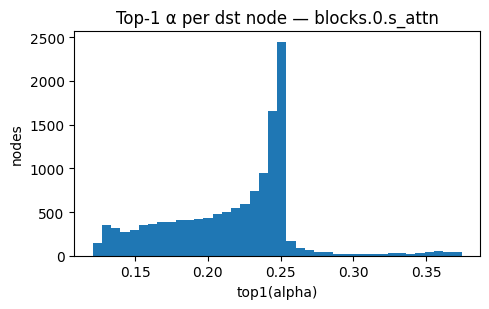

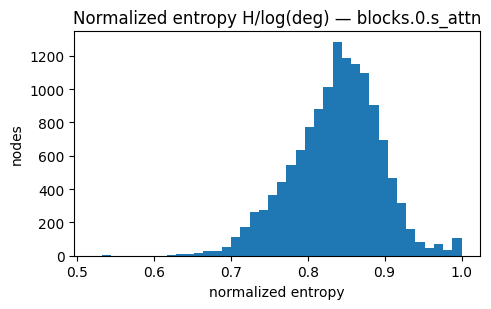

Layer: blocks.0.t_attn  (heads=4)
  Top1 mean=0.5000 | frac(top1>=0.9)=0.000 | {'p50': 0.5, 'p90': 0.5, 'p95': 0.5, 'p99': 0.5}
  nH mean=1.0000 | frac(nH<=0.5)=0.000 | {'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}


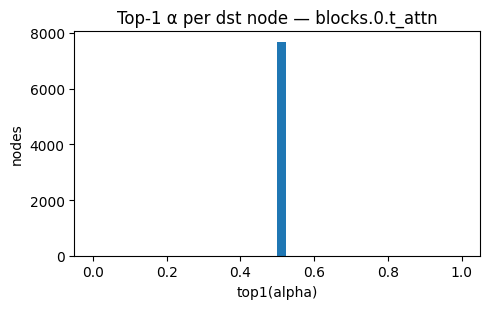

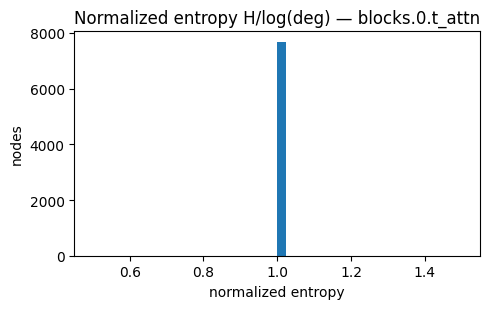

Layer: blocks.1.s_attn  (heads=4)
  Top1 mean=0.1167 | frac(top1>=0.9)=0.000 | {'p50': 0.10199693590402603, 'p90': 0.16202270984649658, 'p95': 0.18331986665725708, 'p99': 0.2961711585521698}
  nH mean=0.9893 | frac(nH<=0.5)=0.000 | {'p50': 0.9986336827278137, 'p90': 0.9998779892921448, 'p95': 0.9999313354492188, 'p99': 0.9999767541885376}


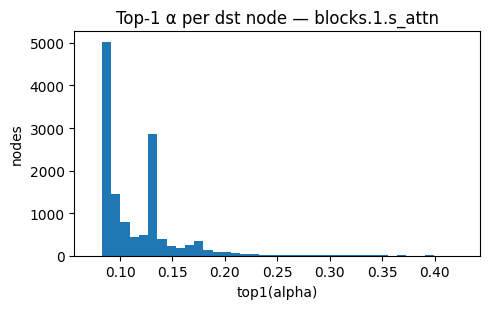

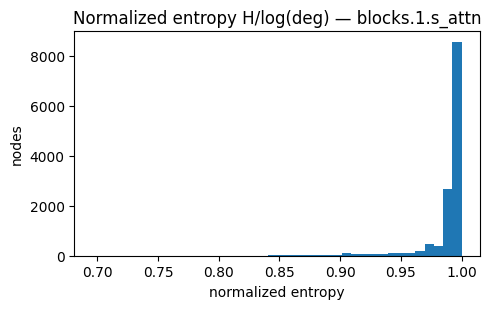

Layer: blocks.1.t_attn  (heads=4)
  Top1 mean=0.5000 | frac(top1>=0.9)=0.000 | {'p50': 0.5, 'p90': 0.5, 'p95': 0.5, 'p99': 0.5}
  nH mean=1.0000 | frac(nH<=0.5)=0.000 | {'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}


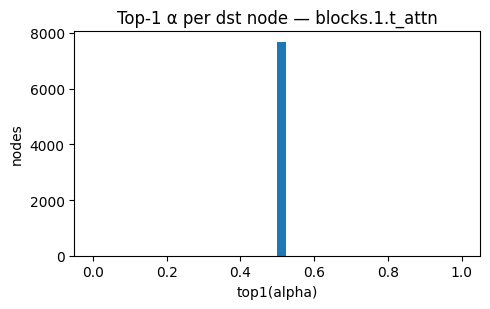

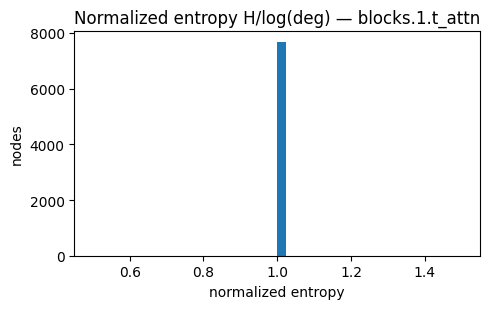

Layer: blocks.2.s_attn  (heads=4)
  Top1 mean=0.1182 | frac(top1>=0.9)=0.000 | {'p50': 0.1065191924571991, 'p90': 0.16273823380470276, 'p95': 0.18251942098140717, 'p99': 0.2762163579463959}
  nH mean=0.9896 | frac(nH<=0.5)=0.000 | {'p50': 0.9974972605705261, 'p90': 0.9998645186424255, 'p95': 0.9999228119850159, 'p99': 0.9999710321426392}


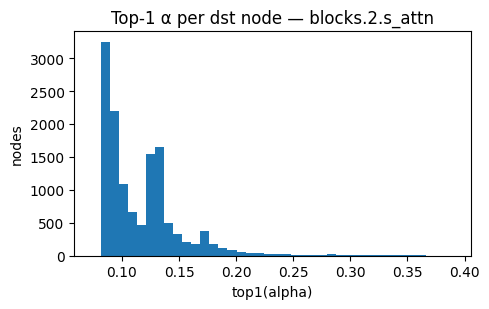

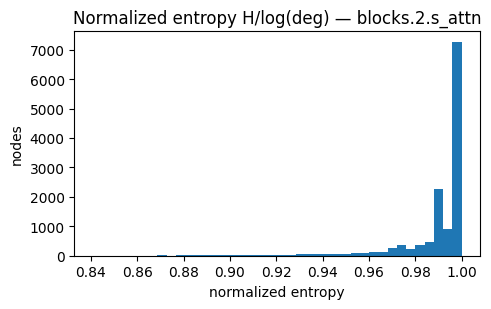

Layer: blocks.2.t_attn  (heads=4)
  Top1 mean=0.5000 | frac(top1>=0.9)=0.000 | {'p50': 0.5, 'p90': 0.5, 'p95': 0.5, 'p99': 0.5}
  nH mean=1.0000 | frac(nH<=0.5)=0.000 | {'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}


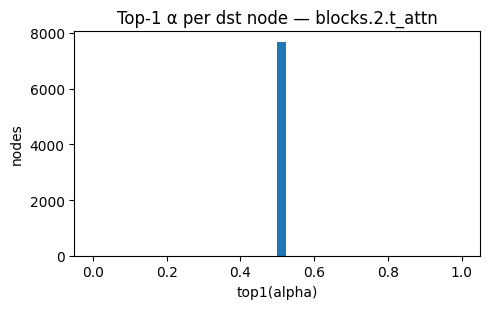

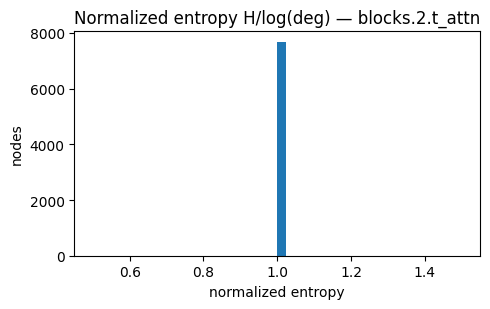

Layer: blocks.3.s_attn  (heads=4)
  Top1 mean=0.1344 | frac(top1>=0.9)=0.000 | {'p50': 0.12703406810760498, 'p90': 0.18854640424251556, 'p95': 0.2264530509710312, 'p99': 0.3703102469444275}
  nH mean=0.9832 | frac(nH<=0.5)=0.000 | {'p50': 0.9930453300476074, 'p90': 0.9996150135993958, 'p95': 0.9998566508293152, 'p99': 0.999955415725708}


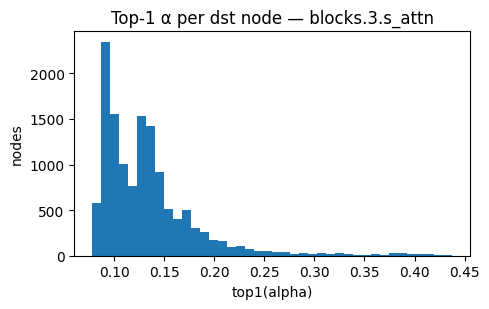

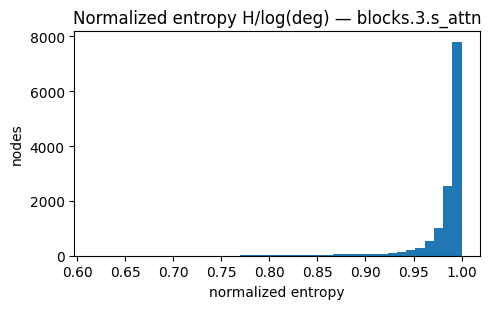

Layer: blocks.3.t_attn  (heads=4)
  Top1 mean=0.5000 | frac(top1>=0.9)=0.000 | {'p50': 0.5, 'p90': 0.5, 'p95': 0.5, 'p99': 0.5}
  nH mean=1.0000 | frac(nH<=0.5)=0.000 | {'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}


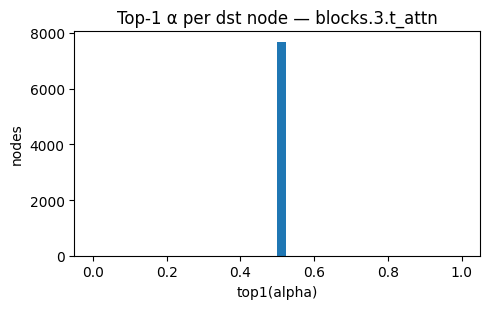

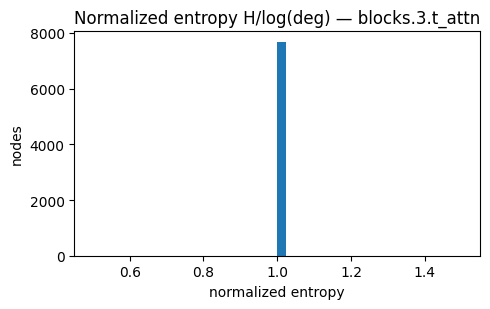


Tips:
 • If many nodes have top1>=0.9 and nH_mean<0.6 ⇒ attention too sharp. Try lower gamma or higher floor.
 • If nH_mean≈1.0 and top1≈1/degree ⇒ nearly uniform (too flat). Consider gamma↑ or raw mode.


In [13]:
# %% [code] -- Run attention inspection safely
# Ensure `model` and `val_loader` are available (from earlier cells).
try:
    model  # noqa
    val_loader  # noqa
except NameError:
    raise RuntimeError("Please define `model` and `val_loader` first (run previous cells).")

# Patch and inspect (max_batches=2 for speed; increase if needed)
patch_gat_for_alpha(model)
inspect_alpha(model, val_loader, device, max_batches=2, plot=True)


## 🔥 Attention Heatmap（per-dst Top‑K Neighbour）- Run after the main training below

将每个**目标节点（dst）**的入边注意力分布画成热力图：每一行对应一个 dst 节点，每列对应该节点 **Top‑K** 入邻居的注意力 α（按从大到小排序）。

**用法：**
1. 确保前面的注意力体检已运行过（或至少 `patch_gat_for_alpha(model)` 并在 `val_loader` 上前向过一批）。
2. 运行下方代码，必要时改 `layer_name/top_k/num_rows`。


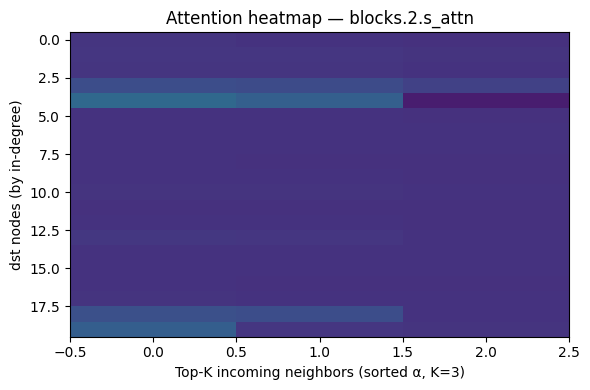

In [23]:
## 新的
import numpy as np

def _pick_layer(model, prefer="blocks.2.t_attn"):
    layers = list(getattr(model, "_alpha_captures", {}).keys())
    if not layers:
        return None, []
    # 先精确找 prefer
    for name in layers:
        if name == prefer:
            return name, layers
    # 再找任意 t_attn
    for name in layers:
        if name.endswith(".t_attn"):
            return name, layers
    # 最后退到第一个
    return layers[0], layers

@torch.no_grad()
def plot_attention_heatmap(model, loader, device, layer_name=None, top_k=10, num_rows=20, max_batches_to_warmup=1):
    if not hasattr(model, "_alpha_captures") or not model._alpha_captures:
        print("[Heatmap] Model not patched; patching now...")
        patch_gat_for_alpha(model)
        if not getattr(model, "_alpha_captures", {}):
            print("[Heatmap] No GATConv layers found. Abort.")
            return

    # warmup
    model.eval()
    for b, data in enumerate(loader):
        data = data.to(device)
        _ = model(data)
        if (b+1) >= max_batches_to_warmup:
            break

    # pick layer
    if layer_name is None:
        layer_name, layers = _pick_layer(model, prefer="blocks.2.t_attn")
    else:
        layers = list(model._alpha_captures.keys())
    if layer_name not in model._alpha_captures:
        print(f"[Heatmap] Unknown layer_name: {layer_name}. Available:", layers); return
    cap = model._alpha_captures[layer_name]
    alpha, ei = cap.last_alpha, cap.last_edge_index
    if alpha is None or ei is None:
        print("[Heatmap] This layer has no captured data yet."); return

    # heads 平均
    if alpha.dim() == 2:
        alpha = alpha.mean(dim=1)
    alpha = alpha.detach().cpu()
    src = ei[0].detach().cpu(); dst = ei[1].detach().cpu()

    # 选入度≥1 的 dst，并按入度取前 num_rows
    udst, cnt = torch.unique(dst, return_counts=True)
    mask = cnt >= 1
    if mask.sum() == 0:
        print("[Heatmap] No dst nodes with in-degree >= 1."); return

    degs = cnt[mask]
    max_in_deg = int(degs.max().item())
    top_k = min(top_k, max_in_deg if max_in_deg > 0 else 1)

    dst_pick = udst[mask][torch.argsort(degs, descending=True)[:num_rows]]


   # 组装 H
    H = []
    for d in dst_pick.tolist():
        idx = (dst == d).nonzero(as_tuple=False).view(-1)
        a = alpha[idx]
        top = a[torch.argsort(a, descending=True)][:top_k].numpy()
        if top.shape[0] < top_k:

            top = np.pad(top, (0, top_k - top.shape[0]), constant_values=np.nan)
        H.append(top)
    H = np.vstack(H)

    # 画图
    plt.figure(figsize=(6,4))
    plt.imshow(H, aspect='auto', interpolation='nearest', vmin=0, vmax=1)
    plt.title(f"Attention heatmap — {layer_name}")
    plt.xlabel(f"Top-K incoming neighbors (sorted α, K={top_k})")
    plt.ylabel("dst nodes (by in-degree)")
    plt.tight_layout()
    plt.show()

plot_attention_heatmap(model, val_loader, device,
                       layer_name="blocks.2.s_attn", top_k=3, num_rows=20)


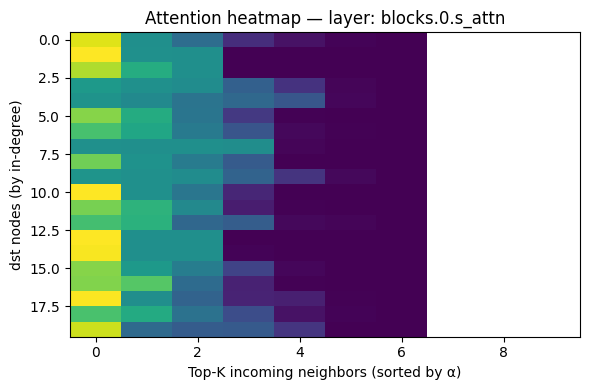

In [16]:
# %% [code] -- Attention heatmap (safe)
import torch
import numpy as np
import matplotlib.pyplot as plt

def _get_captured_layers(model):
    return list(getattr(model, "_alpha_captures", {}).keys())

@torch.no_grad()
def plot_attention_heatmap(model, loader, device, layer_name=None, top_k=10, num_rows=20, max_batches_to_warmup=1):
    # Ensure we have patched layers
    if not hasattr(model, "_alpha_captures") or not model._alpha_captures:
        print("[Heatmap] Model not patched; patching now...")
        patch_gat_for_alpha(model)
        if not hasattr(model, "_alpha_captures") or not model._alpha_captures:
            print("[Heatmap] No GATConv layers found. Abort.")
            return

    # Warmup: run a small number of batches to capture alphas
    model.eval()
    done = False
    for b, data in enumerate(loader):
        data = data.to(device)
        _ = model(data)
        if (b+1) >= max_batches_to_warmup:
            break

    # Select a layer
    layers = _get_captured_layers(model)
    if not layers:
        print("[Heatmap] No captured alphas available.")
        return
    if layer_name is None:
        layer_name = layers[0]
    if layer_name not in model._alpha_captures:
        print(f"[Heatmap] Unknown layer_name: {layer_name}. Available:", layers)
        return
    cap = model._alpha_captures[layer_name]
    alpha = cap.last_alpha
    ei = cap.last_edge_index
    if alpha is None or ei is None:
        print("[Heatmap] This layer has no captured data yet. Run a forward pass first.")
        return

    # Average heads if needed -> [E]
    if alpha.dim() == 2:
        alpha = alpha.mean(dim=1)
    alpha = alpha.detach().cpu()
    src = ei[0].detach().cpu()
    dst = ei[1].detach().cpu()

    # Build per-dst lists
    # Choose dst nodes with in-degree >= 2
    unique_dst, counts = torch.unique(dst, return_counts=True)
    mask = counts >= 2
    dst_candidates = unique_dst[mask]
    if dst_candidates.numel() == 0:
        print("[Heatmap] No dst nodes with in-degree >= 2; nothing to plot.")
        return

    # Select top dst nodes by in-degree
    degs = counts[mask]
    deg_order = torch.argsort(degs, descending=True)
    dst_pick = dst_candidates[deg_order[:num_rows]]

    # For each picked dst, collect alpha of incoming edges, sort desc, take top_k
    H = []
    for d in dst_pick.tolist():
        idx = (dst == d).nonzero(as_tuple=False).view(-1)
        a = alpha[idx]
        # sort descending
        order = torch.argsort(a, descending=True)
        top = a[order][:top_k].numpy()
        if top.shape[0] < top_k:
            top = np.pad(top, (0, top_k - top.shape[0]), constant_values=np.nan)
        H.append(top)
    H = np.vstack(H) if len(H) else None
    if H is None or H.size == 0:
        print("[Heatmap] Nothing to plot after selection.")
        return

    # Plot heatmap
    plt.figure(figsize=(6, 4))
    plt.imshow(H, aspect='auto', interpolation='nearest')  # default colormap
    plt.title(f"Attention heatmap — layer: {layer_name}")
    plt.xlabel("Top‑K incoming neighbors (sorted by α)")
    plt.ylabel("dst nodes (by in-degree)")
    plt.tight_layout()
    plt.show()

# Example run (adjust as needed):
plot_attention_heatmap(model, val_loader, device, layer_name= None, top_k=10, num_rows=20)


## Main Training

Validation loss decreased (inf --> 7.649375).  Saving model ...
Ep001 | train=9.4276 | val=7.6494 | lr=3.00e-04
Validation loss decreased (7.649375 --> 7.632556).  Saving model ...
Ep002 | train=9.1061 | val=7.6326 | lr=3.00e-04
Validation loss decreased (7.632556 --> 7.611694).  Saving model ...
Ep003 | train=8.9747 | val=7.6117 | lr=3.00e-04
Validation loss decreased (7.611694 --> 7.508237).  Saving model ...
Ep004 | train=8.8401 | val=7.5082 | lr=3.00e-04
Validation loss decreased (7.508237 --> 7.294239).  Saving model ...
Ep005 | train=8.6290 | val=7.2942 | lr=3.00e-04
Validation loss decreased (7.294239 --> 6.960119).  Saving model ...
Ep006 | train=8.2816 | val=6.9601 | lr=3.00e-04
Validation loss decreased (6.960119 --> 6.577029).  Saving model ...
Ep007 | train=7.6887 | val=6.5770 | lr=3.00e-04
Validation loss decreased (6.577029 --> 6.515839).  Saving model ...
Ep008 | train=7.1753 | val=6.5158 | lr=3.00e-04
Validation loss decreased (6.515839 --> 6.047657).  Saving model ...


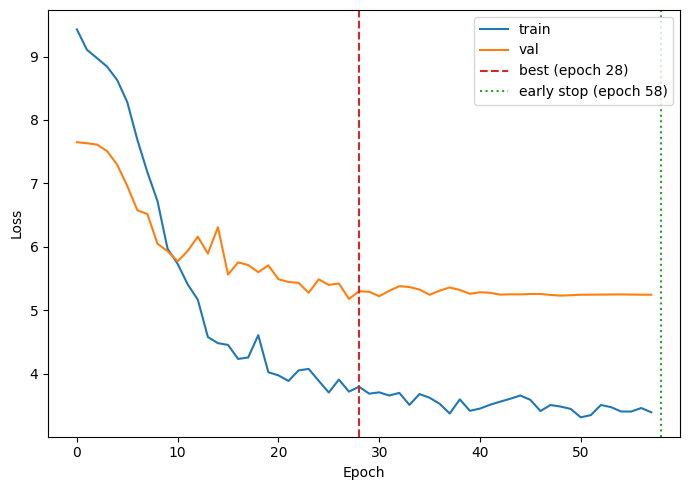

In [11]:
# ========= Main training (SeqGAT, temporal mode 固定后开训) =========
import os, json, torch, torch.nn as nn
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from scripts.pytorchtools import EarlyStopping
def train_one_epoch(model, loader, opt, device, cfg):
    model.train()
    # 和 baseline 对齐：L1Loss（也可改 SmoothL1Loss）
    use_l1 = True
    loss_fn = nn.L1Loss(reduction='none') if use_l1 else nn.SmoothL1Loss(reduction='none')
    wY, wTh = tuple(cfg.get('loss_weights', [1.0, 1.0]))
    epoch_loss, n = 0.0, 0

    for data in loader:
        data = data.to(device)
        pred = model(data)                    # [B,2]
        y = _select_y(data.y, pred, cfg)      # [B,2]

        lv = loss_fn(pred, y)                 # [B,2]
        loss = wY*lv[:,0].mean() + wTh*lv[:,1].mean()

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        epoch_loss += loss.item() * y.size(0)
        n += y.size(0)

    return epoch_loss / max(n, 1)
def evaluate_loss(model, loader, device, cfg):
    model.eval()
    use_l1 = True
    loss_fn = nn.L1Loss(reduction='none') if use_l1 else nn.SmoothL1Loss(reduction='none')
    wY, wTh = tuple(cfg.get('loss_weights', [1.0, 1.0]))
    tot, n = 0.0, 0
    for data in loader:
        data = data.to(device)
        pred = model(data)
        y = _select_y(data.y, pred, cfg)
        lv = loss_fn(pred, y)
        loss = wY*lv[:,0].mean() + wTh*lv[:,1].mean()
        tot += loss.item() * y.size(0)
        n += y.size(0)
    return tot / max(n, 1)
def _select_y(y, pred, cfg):
    """
    y:   Tensor from Data.y, shape [B*D] 或 [B, D] 或 [D]
    pred: 模型输出 [B, 2]
    cfg:  可以在 YAML 里加 label_indices: [iY, iTheta]
    """
    if y.dim() == 1:
        y = y.view(pred.size(0), -1)     # PyG 会把 [2] 拼成 [B*2]，这里还原成 [B,2]
    elif y.dim() == 2 and y.size(0) != pred.size(0):
        # 偶发对不齐（极少），按 batch 还原
        y = y.view(pred.size(0), -1)

    # 如果标签不是2维，按索引挑两列
    if y.size(-1) != 2:
        idx = cfg.get('label_indices', None)
        if idx is None:
            raise ValueError(
                f"y 有 {y.size(-1)} 维，请在 YAML 里设置 label_indices: [iY, iTheta] 指定两列。"
            )
        y = y[:, idx]
    return y
@torch.no_grad()
def evaluate_mae(model, loader, device, cfg):
    model.eval()
    ys, ps = [], []
    for data in loader:
        data = data.to(device)
        pred = model(data)
        y = _select_y(data.y, pred, cfg)
        ys.append(y); ps.append(pred)
    if not ys:
        return {'MAE_Y': float('nan'), 'MAE_theta': float('nan')}
    y = torch.cat(ys, 0); p = torch.cat(ps, 0)
    m = metrics_mae_rmse(y, p)
    return {'MAE_Y': m['MAE_Y'], 'MAE_theta': m['MAE_theta']}


def metrics_mae_rmse(y_true, y_pred):
    with torch.no_grad():
        err = (y_true - y_pred).abs()
        return {
            'MAE_Y':      err[:,0].mean().item(),
            'MAE_theta':  err[:,1].mean().item(),
            'RMSE_Y':     torch.sqrt(((y_true[:,0]-y_pred[:,0])**2).mean()).item(),
            'RMSE_theta': torch.sqrt(((y_true[:,1]-y_pred[:,1])**2).mean()).item(),
        }



def plot_history(history, best_epoch=None, stop_epoch=None, save_to=None):
    """
    best_epoch: 验证集最优(最小 val loss)的 epoch（从 1 开始计）
    stop_epoch: 触发 early stopping 的 epoch（从 1 开始计）
    """
    plt.figure(figsize=(7,5))
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"],   label="val")

    if best_epoch is not None:
        plt.axvline(best_epoch, color="tab:red", linestyle="--", label=f"best (epoch {best_epoch})")
    if stop_epoch is not None:
        plt.axvline(stop_epoch, color="tab:green", linestyle=":", label=f"early stop (epoch {stop_epoch})")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, bbox_inches='tight')
    plt.show()


# 0) 固定主实验用的时序模式（你已决定 raw；若改用 calibrated/binary，改这里即可）
cfg['temconfigure'].update({'mode': 'raw'})   # or: {'mode':'calibrated','lo_q':0.05,'hi_q':0.995,'gamma':1.2,'floor':0.0}

# 1) 重建数据集与切分（seed 一致）
set_seed(cfg.get('seed',0))
ds = load_dataset(
    cfg['data_root'],
    glob_pattern=cfg.get('glob','*.pt'),
    field_map=cfg.get('field_map',{}),
    tip_num=cfg.get('tip_num'),
    k_last_frames=cfg.get('k_last_frames'),
)
n_total = len(ds); n_val = int(n_total * cfg.get('val_ratio', 0.2)); n_train = n_total - n_val
train_set, val_set = random_split(
    ds, [n_train, n_val],
    generator=torch.Generator().manual_seed(cfg.get('seed',0))
)

# 2) attach 时序管线（根据 temconfigure 产出 edge_attr_t / 决定 edge_dim_t）
train_set, edge_dim_t_eff = attach_temporal_pipeline(train_set, cfg)
val_set,   _             = attach_temporal_pipeline(val_set,   cfg)
cfg['edge_dim_t'] = int(edge_dim_t_eff)  # 0/1

# 3) DataLoader
train_loader = DataLoader(train_set, batch_size=cfg.get('batch_size',8), shuffle=True,  num_workers=cfg.get('num_workers',0))
val_loader   = DataLoader(val_set,   batch_size=cfg.get('batch_size',8), shuffle=False, num_workers=cfg.get('num_workers',0))

# 4) 构建模型（读取 edge_dim_t / time_emb_dim）
model = SeqGAT(
    in_dim=cfg['in_dim'],
    hidden_dim=cfg.get('hidden_dim',128),
    num_layers=cfg.get('num_layers',4),
    heads=cfg.get('heads',4),
    edge_dim_s=cfg.get('edge_dim_s',0),
    edge_dim_t=cfg['edge_dim_t'],
    time_emb_dim=cfg.get('time_emb_dim',16),  
    dropout=cfg.get('dropout',0.1),
    readout=cfg.get('readout','meanmax'),
).to(device)

# 5) 优化器/调度/早停（与 baseline 对齐）
out_dir = cfg.get('out_dir', './outputs')
os.makedirs(out_dir, exist_ok=True)
Opt = torch.optim.Adam if cfg.get('optim','adam').lower()=='adam' else torch.optim.AdamW
wd  = cfg.get('weight_decay', 0.0 if cfg.get('optim','adam').lower()=='adam' else 1e-4)
opt = Opt(model.parameters(), lr=cfg.get('lr', 3e-4), weight_decay=wd)

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=3, threshold=1e-3, verbose=True
)

patience  = int(cfg.get("patience", 30))
es_delta  = float(cfg.get("es_delta", 0.0))
ckpt_name = "seqgat_best.pth"
ckpt_path = os.path.join(out_dir, ckpt_name)
early_stopping = EarlyStopping(patience=patience, verbose=True, delta=es_delta, path=ckpt_path)

history = {"train_loss": [], "val_loss": []}
best_val = float('inf'); best_epoch = None; stop_epoch = None
epochs = int(cfg.get('epochs', 200))

# 6) 训练（损失同 baseline：L1/MSE 由你的 train_one_epoch/evaluate_loss 决定）
for epoch in range(1, epochs+1):
    tr = train_one_epoch(model, train_loader, opt, device, cfg)   # 你已有的函数：返回 train_loss
    vl = evaluate_loss(model, val_loader, device, cfg)            # 你已有的函数：返回 val_loss

    history["train_loss"].append(tr); history["val_loss"].append(vl)
    sched.step(vl)

    if vl < best_val - 1e-12:
        best_val = vl; best_epoch = epoch

    early_stopping(vl, model)
    print(f"Ep{epoch:03d} | train={tr:.4f} | val={vl:.4f} | lr={opt.param_groups[0]['lr']:.2e}")
    if early_stopping.early_stop:
        stop_epoch = epoch
        print(f"Early stopping at epoch {epoch} (patience={patience}, monitor=val_loss)")
        break

# 7) 载入最佳，汇报 MAE（分维 Y/θ；你的 evaluate_mae 已支持 label_indices）
state = torch.load(ckpt_path, map_location=device)   # 老师的保存方式：仅 state_dict
model.load_state_dict(state)

mae_tr = evaluate_mae(model, train_loader, device, cfg)
mae_va = evaluate_mae(model, val_loader, device, cfg)
print(f"\n[MAE] Train: Y={mae_tr.get('MAE_Y', float('nan')):.4f} | θ={mae_tr.get('MAE_theta', float('nan')):.4f}")
print(f"[MAE] Valid: Y={mae_va.get('MAE_Y', float('nan')):.4f} | θ={mae_va.get('MAE_theta', float('nan')):.4f}")

# 8) 存历史 & 画曲线
with open(os.path.join(out_dir, "loss_history.json"), "w") as f:
    json.dump(history, f, indent=2)

plot_history(
    history,
    best_epoch=best_epoch,
    stop_epoch=stop_epoch,
    save_to=os.path.join(out_dir, "loss_plot.png"),
)


## Test Model

In [ ]:
# # ===== Build TEST loader with the same pipeline (mode='raw') =====
# from torch_geometric.loader import DataLoader
# import os, torch

# def build_split_loader(root, cfg):
#     ds = load_dataset(                      # ← 用传入的 root
#         root,
#         glob_pattern=cfg.get('glob_test', 'Test_*.pt'),  # 也可在 cfg 里放 glob_test
#         field_map=cfg.get('field_map', {}),
#         tip_num=cfg.get('tip_num'),
#         k_last_frames=cfg.get('k_last_frames'),
#     )
#     ds, _ = attach_temporal_pipeline(ds, cfg)  # 与训练同一 temconfigure（raw）
#     return DataLoader(ds, batch_size=cfg.get('batch_size', 8),
#                       shuffle=False, num_workers=cfg.get('num_workers', 0))

# # ---------- 1) 构建 Test Loader ----------
# test_path = cfg.get('data_root_test', None)
# if test_path and os.path.exists(test_path):
#     test_list = torch.load(test_path)
#     test_list, _ = attach_temporal_pipeline(test_list, cfg)  # 保证有 edge_attr_t 等
#     test_loader = DataLoader(test_list, batch_size=cfg.get('batch_size', 8), shuffle=False)
# else:
#     raise FileNotFoundError("请在 cfg['data_root_test'] 指定测试集路径，或检查路径是否存在。")


# # ---------- 2) 加载 best 权重（训练阶段早停保存的）----------
# ckpt_path = os.path.join(cfg.get('out_dir', './outputs'), "seqgat_best.pth")
# state = torch.load(ckpt_path, map_location=device)   # 训练里是 state_dict
# model.load_state_dict(state)
# model.eval()

# # ---------- 3) 评估（与你训练时一致的 evaluate_mae）----------
# mae_te = evaluate_mae(model, test_loader, device, cfg)  # 返回 dict: {'MAE_Y':..., 'MAE_theta':...}
# print(f"[TEST] Y={mae_te['MAE_Y']:.4f} | θ={mae_te['MAE_theta']:.4f}")

# #导出逐样本预测，方便画散点/误差分析
# import pandas as pd
# pred_rows = []
# with torch.no_grad():
#     for data in test_loader:
#         data = data.to(device)
#         out = model(data)
#         y = data.y.view_as(out) if data.y.shape != out.shape else data.y
#         pred_rows.append(pd.DataFrame(
#             torch.cat([y.cpu(), out.cpu(), (out-y).abs().cpu()], dim=1).numpy(),
#             columns=["Y_true","θ_true","Y_pred","θ_pred","|ΔY|","|Δθ|"]
#         ))
# df_pred = pd.concat(pred_rows, ignore_index=True)
# save_csv = os.path.join(cfg.get('out_dir','./outputs'), "test_preds.csv")
# df_pred.to_csv(save_csv, index=False)
# print("Saved per-sample predictions ->", save_csv)


<class 'list'> 108
<class 'torch_geometric.data.data.Data'>
